## Sentiment Analysis of Business Reviews using a mullti- input classification model with Keras.
## Introduction
Sites such as Yelp have a star rating system that lets users easily see what the general opinion about a particular establishment is without having to read all the reviews for that particular business. However, there is an abundance of user generated information online from social media platforms like twitter, facebook or blog posts where users express their sentiment about a particular product or business. 
My goal is to create a text classification model that classifies user reviews regarding different business, into one of the three predefined categories i.e. "good", "bad", and "average" based both the text of the review and the associated metadata of the review.
The file contains more than 5.2 million reviews about different businesses, including restaurants, bars, dentists, doctors, beauty salons, etc. I will only be using the first 200,000 records to train my model because of my hardware limitation.
I will be using Keras Functional API because it supports multiple inputs models to create a deep learning model.
 
 **ABOUT MY DATASET** -Yelp is an American multinational corporation founded in
 2004 which aimed at helping people locate local business based on social networking functionally and reviews. The main purpose of Yelp is to provide a platform for customers to write review along with an open ended comment.
 Yelp data is reliable, up-to-date and has a wide coverage of all kinds of businesses.

In [0]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.keras import backend 


In [3]:
#importing the necessary libraries 
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from keras.layers.merge import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input, layers
import pandas as pd
import numpy as np
import re

Using TensorFlow backend.


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [0]:
import pandas as pd 
data=pd.read_csv('gdrive/My Drive/yelp_review.csv')

I will be using the top 200,000 of the over 5million reviews for my work due to hardware constraints.

In [0]:
yelp_data= data[:200000]

In [7]:
yelp_data.head(10)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0
5,HRPm3vEZ_F-33TYVT7Pebw,_4iMDXbXZ1p1ONG297YEAQ,8QWPlVQ6D-OExqXoaD2Z1g,5,2014-09-24,Cycle Pub Las Vegas was a blast! Got a groupon...,1,0,0
6,ymAUG8DZfQcFTBSOiaNN4w,u0LXt3Uea_GidxRW1xcsfg,9_CGhHMz8698M9-PkVf0CQ,4,2012-05-11,Who would have guess that you would be able to...,0,0,2
7,8UIishPUD92hXtScSga_gw,u0LXt3Uea_GidxRW1xcsfg,gkCorLgPyQLsptTHalL61g,4,2015-10-27,Always drove past this coffee house and wonder...,1,0,0
8,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg,5r6-G9C4YLbC7Ziz57l3rQ,3,2013-02-09,"Not bad!! Love that there is a gluten-free, ve...",1,0,0
9,WF_QTN3p-thD74hqpp2j-Q,u0LXt3Uea_GidxRW1xcsfg,fDF_o2JPU8BR1Gya--jRIA,5,2016-04-06,Love this place!\n\nPeggy is great with dogs a...,3,0,0


In [8]:
yelp_data.shape

(200000, 9)

Converting the numerical values for the reviews into categorical ones and add a new column "reviews_score" to the dataset. Stars rating column. if stars =4 or 5,reviews score is classified as good if stars = 2 0r 3, reviews score is classified as average if stars = 1, reviews score is classified as bad.

In [0]:
#preprocessing
bins = [0,1,3,5]
names = ['bad', 'average', 'good']
yelp_data['reviews_score'] = pd.cut(yelp_data['stars'], bins, labels=names)

In [10]:
#removing null values
yelp_data.isnull().values.any()#removing null values
print(yelp_data.shape)#looking at the dimension of our data
yelp_data.head()#viewing he first few columns of the data

(200000, 10)


,review_id,user_id,business_id,stars,date,text,useful,funny,cool,reviews_score
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,good
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,good
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,good
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,good
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,good


The dataframe now contains 10 columns including the newly added reviews_score column. The text column contains the text of the review while the useful column contains numerical value that represents the count of the people who found the review useful. The funny and cool columns contain the counts of people who found reviews funny or cool, respectively.


**Analysing text of the review-Input1**

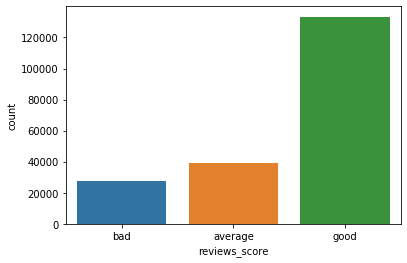

In [11]:
#visualising review score column
import seaborn as sns
sns.countplot(x='reviews_score', data=yelp_data)

In [12]:
yelp_data['reviews_score'].value_counts().sort_values(ascending=False)

good       133289
average     39336
bad         27375
Name: reviews_score, dtype: int64

####133,289 people gave good reviews,33,336 gave average reviews while 27,375 gave bad reviews.


**Analyzing the meta data - using as Input2**

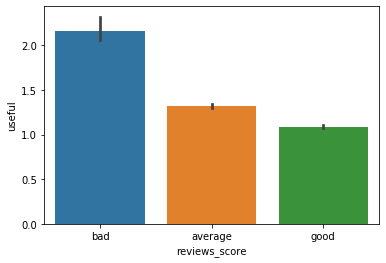

In [13]:
#visualizing 'useful' column
import seaborn as sns
sns.barplot(x='reviews_score', y='useful', data=yelp_data)

From the graph, the average count for reviews marked as useful is the highest for the bad reviews, followed by the average reviews and the good reviews.

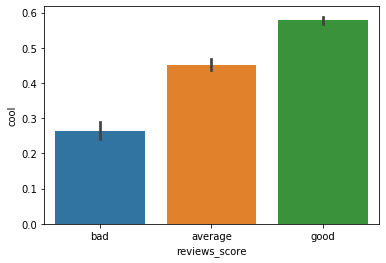

In [14]:
#visualizing 'cool' column
sns.barplot(x='reviews_score', y='cool', data=yelp_data)

mostly good reviews as cool, followed by average and then bad reviews .

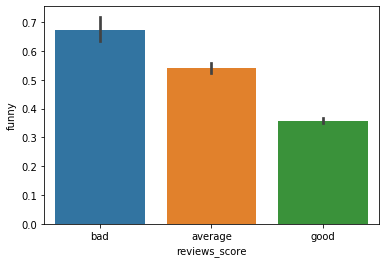

In [15]:
#visualizing the "funny" column
sns.barplot(x='reviews_score', y='funny', data=yelp_data)

Again, most reviews were bad and the least seen as good.

**Using Keras Functional API to create a model with multiple input
The functional API makes it easy to manipulate a large number of intertwined datastreams** 

In [0]:
#seperating the target variable from the feature variables
X = yelp_data.drop('reviews_score', axis=1)#feature variables
y = yelp_data['reviews_score']#target column

Converting texts into integer labels,splitting into train and test sets then converting splitted data into one hot encoded vectors.

In [0]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

#Converting splitted data into one hot encoded vectors
from keras.utils import to_categorical
y_train = to_categorical(y_train) #splitting the target column
y_test = to_categorical(y_test)

### preprocessing the feature variables
i will filter all the text reviews and store them in the list. The text reviews will be cleaned using the preprocess_text function, which removes punctuations and numbers from the text.

In [0]:
#function to pre-process text
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

Creating textual input for the training and test set

In [0]:
X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))
    
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen)) 

Word embeddings
converting textual input for the training and test sets into their numeric indexes using Tokenizer, pad each sequence to the same length (length of the longest sequence or provided override) 

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

Creating word vectors using GloVe

In [0]:
! pip install glove_python

In [0]:
import glove

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [0]:
#creating word embeddings with GloVe
from numpy import array
from numpy import asarray
from numpy import zeros
import io

embeddings_dictionary = dict()
with io.open('/content/gdrive/My Drive/glove.6B.100d.txt', encoding='utf8') as glove_file:
  for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

#embedding matrix
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


Creating meta input for training and test

In [0]:
X2_train = X_train[['useful', 'funny', 'cool']].values
X2_test = X_test[['useful', 'funny', 'cool']].values

The first submodel will accept textual input in the form of text reviews. This submodel will consist of an input shape layer, an embedding layer, and an LSTM layer of 128 neurons. The second submodel will accept input in the form of meta information from the useful, funny, and cool columns. The second submodel also consist of three layers. An input layer and two dense layers. I added a dropout to prevent overfitting.

In [0]:
from tensorflow.python.keras.layers import Dense
text_input = Input(shape=(maxlen,))#input shape set to the length of the input sentence 
metadata_input = Input(shape=(3,)) #set to the three metadata columns...

embedding_layer = layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(text_input)#embedded text in first submodel, accepts input1
LSTM_Layer_1 = layers.LSTM(128)(embedding_layer)# A LSTM will transform the vector sequence into a single vector
# containing information about the entire sequence

dense_layer_1 = layers.Dense(10, activation='relu')(metadata_input) #numerical second submodel accepts input2
dense_layer_2 = layers.Dense(10, activation='relu')(dense_layer_1)
#merging the inputs
concatenated = layers.concatenate([LSTM_Layer_1, dense_layer_2],axis=-1)
#classifier
dense_layer_3 = layers.Dense(10, activation='relu')(concatenated)#to allowing the LSTM and Embedding layer to be trained smoothly even though the main loss will be much higher in the model.

output_dropout = layers.Dropout(0.2)(dense_layer_3)#dropout to prevent overfitting#dropout to prevent overfitting(NOTE:set dropout after establishing overfitting)
answer = Dense(3, activation='softmax')(output_dropout)


In [0]:

#established a baseline model in the final notebook, then increase models to get the best.
#final model
model = tf.keras.Model([text_input, metadata_input],answer)

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     10488300    input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           40          input_2[0][0]                    
____________________________________________________________________________________________

A plot of the model network

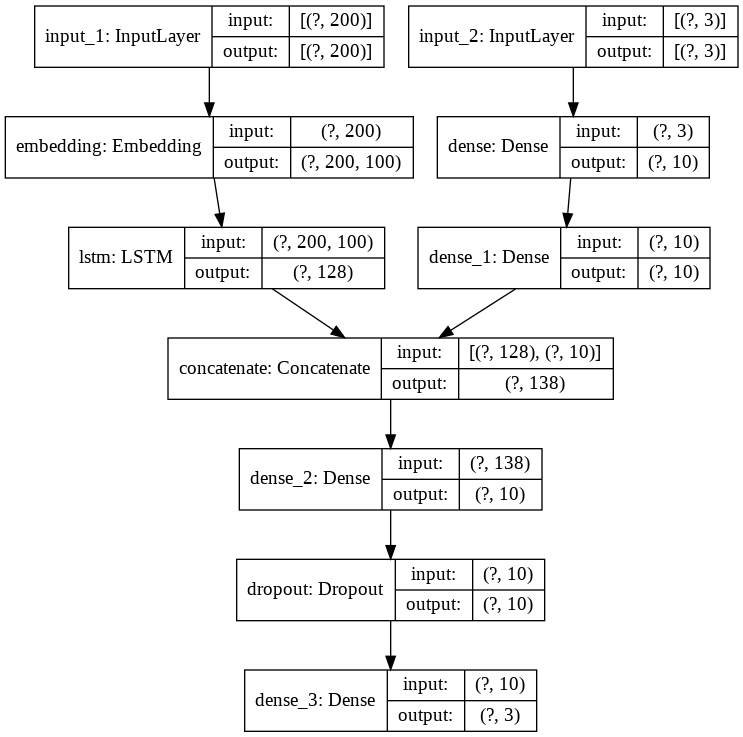

In [33]:
tf.keras.utils.plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

FITTTING THE MODEL

In [35]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2) #no of epochs should be set to the maximum for training

Train on 128000 samples, validate on 32000 samples
Epoch 1/10
128000/128000 [==============================] - 832s 6ms/sample - loss: 0.7730 - acc: 0.6899 - val_loss: 0.6276 - val_acc: 0.7454
Epoch 2/10
128000/128000 [==============================] - 827s 6ms/sample - loss: 0.5729 - acc: 0.7614 - val_loss: 0.4855 - val_acc: 0.7936
Epoch 3/10
128000/128000 [==============================] - 828s 6ms/sample - loss: 0.4815 - acc: 0.8016 - val_loss: 0.4459 - val_acc: 0.8211
Epoch 4/10
128000/128000 [==============================] - 818s 6ms/sample - loss: 0.4688 - acc: 0.8148 - val_loss: 0.4319 - val_acc: 0.8253
Epoch 5/10
128000/128000 [==============================] - 825s 6ms/sample - loss: 0.4350 - acc: 0.8266 - val_loss: 0.4278 - val_acc: 0.8364
Epoch 6/10
128000/128000 [==============================] - 822s 6ms/sample - loss: 0.4119 - acc: 0.8346 - val_loss: 0.4101 - val_acc: 0.8278
Epoch 7/10
128000/128000 [==============================] - 822s 6ms/sample - loss: 0.3903 - acc:

the training accuracy is 85.74 while validation accuracy is 84.74. traing loss is 0.3483 while validation loss is 0.3912

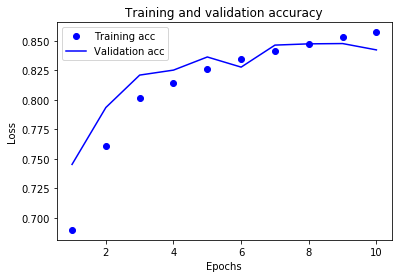

In [38]:
#plot of training and validation accuracy
import matplotlib.pyplot as plt
plt.clf() 
acc = history_dict['acc'] 
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

training abd validation accuracy and loss are pretty close so i would say no overfitting.

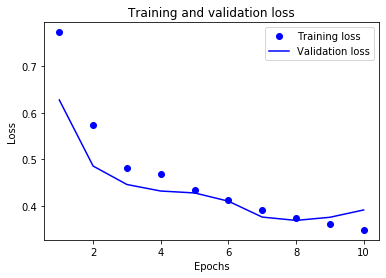

In [37]:
#Plot of the training and validation loss
history_dict = history.history
history_dict.keys()
acc = history.history["acc"]
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluating the model on the test set

In [39]:
#evaluate the model on test set
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)#pass both the test inputs

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

40000/40000 [==============================] - 85s 2ms/sample - loss: 0.3859 - acc: 0.8444
Test Score: 0.38589756544828413
Test Accuracy: 0.8444


The test accuracy is 84.44%. 


Final plot of training and testing set accuracy and loss.

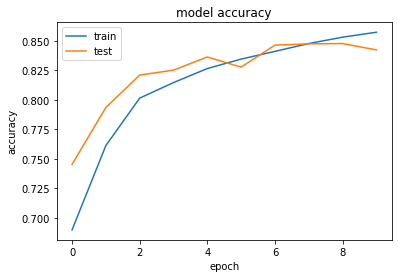

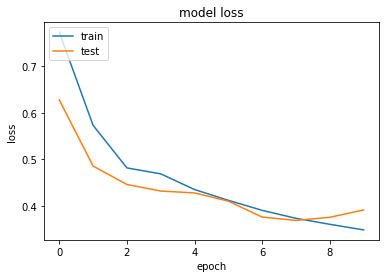

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The differences for loss and accuracy values is minimal between the training and test sets, this means the model is not overfitting.

### Conclusion.Yelp	reviews	and	ratings	are	important	source	of	information	to	make	informed decisions	about	a	venue.	Further classification	of	yelp	reviews	into relevant	categories	can	help	users	to	make	an	informed	decision	based	on	their	personal preferences	for categories,	especially	useful	when	users	do	not have	time	to	read	many	reviews. I have been able to build a multi-input model that classifies business reviews using both textual input and metadata input with an accuracy of 84.44% on the test data.

